In [1]:
# --------------------------------------------------
# CELL 1: Imports & Global Configuration
# --------------------------------------------------
"""
This cell establishes the global environment for our anomaly detection pipeline.

Good ML systems are reproducible and configurable — NOT filled with magic numbers.
Think of this as the control panel for the entire project.

We are building infrastructure that will eventually support:
    Isolation Forest  → baseline
    Dense Autoencoder → next step
    LSTM Autoencoder  → goal
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns
import joblib  # allows saving scalers/models for inference later

sns.set(style="whitegrid")

# --------------------------------------------------
# Reproducibility (VERY IMPORTANT IN ML)
# --------------------------------------------------
np.random.seed(42)

# --------------------------------------------------
# Global Configuration
# --------------------------------------------------
CONFIG = {
    "sequence_length": 100,       # size of sliding time window
    "stride": 5,                  # how many timesteps to skip between sequences
    "batch_size": 50,             # controls RAM usage during preprocessing
    "healthy_files": 100,         # assumption: early machine life = healthy
    "num_files_to_process": 400,  # subset of files for faster testing
    "processed_folder": "../data/processed"  # where processed sequences/memmap go
}

sequence_length = CONFIG["sequence_length"]
batch_size = CONFIG["batch_size"]
stride = CONFIG["stride"]
processed_folder = CONFIG["processed_folder"]

# --------------------------------------------------
# Paths
# --------------------------------------------------
data_folder = "../data/raw/IMS/1st_test"
os.makedirs(processed_folder, exist_ok=True)

# --------------------------------------------------
# Global Scaler
# --------------------------------------------------
"""
CRITICAL CONCEPT:

We fit ONE scaler across healthy data so that
"normal vibration amplitude" has a consistent definition.

If you scaled each file independently:

A failing machine would look statistically normal.

This is one of the most common mistakes in anomaly detection.
"""
scaler = StandardScaler()

# --------------------------------------------------
# TODOs
# --------------------------------------------------
# 1. Consider moving CONFIG to config.yaml for cleaner project structure.
# 2. Save scaler after fitting: joblib.dump(scaler, 'scaler.pkl')
# 3. Add GPU compatibility for future LSTM autoencoder training.


In [2]:
# -----------------------------
# Cell 2: Sliding Window Sequence Generator
# -----------------------------
import numpy as np

def create_sequences(signal, seq_length, stride=5):
    """
    Converts a vibration signal into overlapping sequences.

    Parameters:
    -----------
    signal : np.array, shape (timesteps, features)
    seq_length : int
        Number of timesteps per sequence
    stride : int
        How many timesteps to skip between sequences

    Returns:
    --------
    sequences : np.array, shape (num_sequences, seq_length, features)
    """
    sequences = []
    for i in range(0, len(signal) - seq_length, stride):
        sequences.append(signal[i:i+seq_length])
    return np.array(sequences, dtype=np.float32)

# TODO: Later experiment with stride=1,2,5 to balance correlation and dataset size



In [3]:
# -----------------------------
# Cell 3: Discover & Filter IMS Vibration Files
# -----------------------------
import os

def load_ims_files(folder, seq_length):
    """
    Find all numeric IMS files and filter out files shorter than seq_length.

    Returns
    -------
    valid_files : list[str]
        Only files that can generate at least one sequence
    """
    all_files = []
    for root, dirs, filenames in os.walk(folder):
        for f in filenames:
            if f[-3] == "." and f[-2:].isdigit():
                all_files.append(os.path.join(root, f))
    
    all_files.sort()
    valid_files = [f for f in all_files if len(np.loadtxt(f)) >= seq_length]

    print(f"Total files found: {len(all_files)}")
    print(f"Files valid for processing: {len(valid_files)}")
    return valid_files

files = load_ims_files("../data/raw/IMS/1st_test", CONFIG["sequence_length"])



Total files found: 2156
Files valid for processing: 2156


In [4]:
# --------------------------------------------------
# CELL 4 — Fit GLOBAL Scaler on Healthy Data
# --------------------------------------------------

"""
We assume early machine life is healthy.

AUTOENCODERS REQUIRE THIS.

They must learn what "normal" looks like.
"""

healthy_cutoff = CONFIG["healthy_files"]
sample_files = files[:healthy_cutoff]

all_samples = []

for file_path in sample_files:
    signal = np.loadtxt(file_path, dtype=np.float32).reshape(-1,1)
    all_samples.append(signal)

all_samples = np.vstack(all_samples)

scaler.fit(all_samples)

print("✅ Global scaler fitted.")
print("Samples used:", all_samples.shape)


# Save scaler for inference
joblib.dump(scaler, os.path.join(processed_folder, "global_scaler.save"))

# TODO (EXTREMELY IMPORTANT):
# NEVER train deep models on mixed healthy + failing data.
#
# Next step:
# Save HEALTHY sequences separately for the autoencoder.



✅ Global scaler fitted.
Samples used: (16384000, 1)


['../data/processed\\global_scaler.save']

Signal shape: (20480, 8)


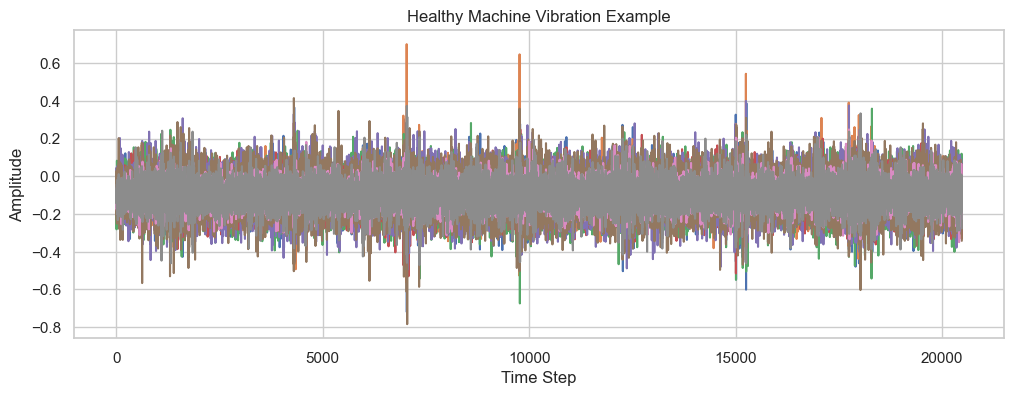

In [5]:
# --------------------------------------------------
# CELL 5: Visualize Raw Signal
# --------------------------------------------------

"""
Golden Rule of ML:

NEVER trust data you haven't plotted.
"""

test_file = files[0]
signal = np.loadtxt(test_file, dtype=np.float32)

print("Signal shape:", signal.shape)

plt.figure(figsize=(12,4))
plt.plot(signal)
plt.title("Healthy Machine Vibration Example")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.show()


# TODO (VERY HIGH VALUE):
# Plot an EARLY file vs a LATE-LIFE file.
#
# When you SEE degradation:
# modeling intuition skyrockets.



In [6]:
# -----------------------------
# Cell 6: Create Memmap Dataset (Professional)
# -----------------------------
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

processed_folder = CONFIG["processed_folder"]
os.makedirs(processed_folder, exist_ok=True)

# Fit scaler on first N files (healthy assumption)
scaler = StandardScaler()
sample_files = files[:100]
all_samples = []

for f in sample_files:
    signal = np.loadtxt(f).reshape(-1,1)
    all_samples.append(signal)

all_samples = np.vstack(all_samples)
scaler.fit(all_samples)
print("✅ Global scaler fitted | Samples used:", all_samples.shape)

# Estimate total sequences
total_sequences = 0
for f in files[:CONFIG["num_files_to_process"]]:
    signal = np.loadtxt(f).reshape(-1,1)
    n_seq = (len(signal) - CONFIG["sequence_length"]) // CONFIG["stride"] + 1
    if n_seq > 0:
        total_sequences += n_seq

print("Estimated total sequences:", total_sequences)

# Create memmap
memmap_file = os.path.join(processed_folder, "all_sequences.dat")
dataset_memmap = np.memmap(memmap_file, dtype='float32', mode='w+', shape=(total_sequences, CONFIG["sequence_length"],1))

# Write sequences into memmap
write_idx = 0
for f in files[:CONFIG["num_files_to_process"]]:
    signal = np.loadtxt(f).reshape(-1,1)
    if len(signal) < CONFIG["sequence_length"]:
        print(f"⚠️ Skipping {f} — too short for sequences")
        continue
    scaled = scaler.transform(signal)
    seqs = create_sequences(scaled, CONFIG["sequence_length"], stride=CONFIG["stride"])
    dataset_memmap[write_idx:write_idx+len(seqs)] = seqs
    write_idx += len(seqs)

dataset_memmap.flush()
print("✅ Memmap dataset created:", memmap_file)


✅ Global scaler fitted | Samples used: (16384000, 1)
Estimated total sequences: 13099600
✅ Memmap dataset created: ../data/processed\all_sequences.dat


In [7]:
# -----------------------------
# Cell 7: Load Sequences Safely
# -----------------------------
import numpy as np

X = np.memmap(memmap_file, dtype='float32', mode='r', shape=(total_sequences, CONFIG["sequence_length"], 1))
print("✅ Memmap loaded:", X.shape)

# Flatten for Isolation Forest
X_flat = X.reshape(X.shape[0], -1)
print("✅ Flattened shape for tree models:", X_flat.shape)

# Subset for fast training
max_samples = 50000
if X_flat.shape[0] > max_samples:
    idx = np.random.choice(X_flat.shape[0], max_samples, replace=False)
    X_flat_train = X_flat[idx]
else:
    X_flat_train = X_flat

print("✅ Training on:", X_flat_train.shape)



✅ Memmap loaded: (13099600, 100, 1)
✅ Flattened shape for tree models: (13099600, 100)
✅ Training on: (50000, 100)


In [8]:
# --------------------------------------------------
# CELL 8: Train Baseline Anomaly Detector
# --------------------------------------------------

"""
Senior ML Rule:

Always beat a simple model before building a complex one.
"""

model = IsolationForest(
    n_estimators=50,
    contamination=0.01,
    random_state=42,
    n_jobs=-1
)

model.fit(X_flat_train)

print("✅ Isolation Forest fit complete")


# TODO:
# Plot score distribution.
#
# Understanding anomaly score shape
# is a massively underrated ML skill.


✅ Isolation Forest fit complete


In [9]:
# --------------------------------------------------
# CELL 9: Batch Scoring
# --------------------------------------------------

batch_size = 100000
num_sequences = X_flat.shape[0]

scores_list = []
preds_list = []

for start in range(0, num_sequences, batch_size):

    end = min(start + batch_size, num_sequences)
    X_batch = X_flat[start:end]

    scores_list.append(model.decision_function(X_batch))
    preds_list.append(model.predict(X_batch))

scores = np.concatenate(scores_list)
preds = np.concatenate(preds_list)

np.save(os.path.join(processed_folder, "anomaly_scores.npy"), scores)

print("✅ Batch scoring complete")


# TODO:
# Save anomaly threshold.
#
# anomaly_threshold = np.percentile(scores, 1)


✅ Batch scoring complete


⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.21.54.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.22.04.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.22.14.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.22.24.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.22.34.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.22.44.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.22.54.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.23.04.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.23.14.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.23.24.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_test\1st_test\2003.10.22.23.34.13, skipping
⚠️ No scores found for ../data/raw/IMS/1st_

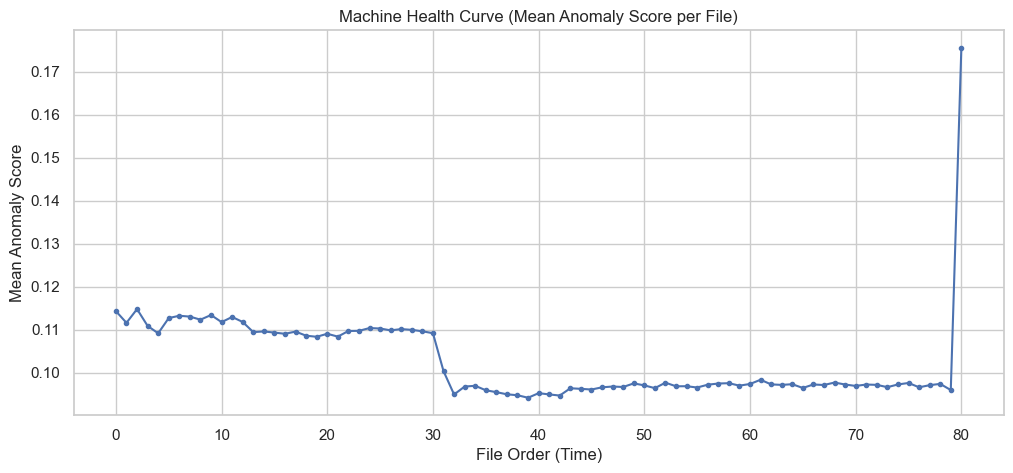

✅ Machine Health Curve plotted | files plotted: 81


In [ ]:
# -----------------------------
# Cell 10: Robust Machine Health Curve
# -----------------------------
file_mean_scores = []
sequence_counter = 0

for f in files[:CONFIG["num_files_to_process"]]:
    signal = np.loadtxt(f).reshape(-1,1)
    num_seqs = (len(signal) - CONFIG["sequence_length"]) // CONFIG["stride"] + 1

    if num_seqs <= 0:
        print(f"⚠️ Skipping {f} — too short for sequences")
        continue

    # Extract the slice of scores for this file
    file_scores = scores[sequence_counter:sequence_counter + num_seqs]

    if len(file_scores) == 0:
        print(f"⚠️ No scores found for {f}, skipping")
        continue

    file_mean_scores.append(file_scores.mean())
    sequence_counter += num_seqs

# Remove accidental NaNs
file_mean_scores = [s for s in file_mean_scores if not np.isnan(s)]

# Plot
plt.figure(figsize=(12,5))
plt.plot(file_mean_scores, marker='o', markersize=3)
plt.title("Machine Health Curve (Mean Anomaly Score per File)")
plt.xlabel("File Order (Time)")
plt.ylabel("Mean Anomaly Score")
plt.grid(True)
plt.show()

print("✅ Machine Health Curve plotted | files plotted:", len(file_mean_scores))
